# Building The StarTrack Model - 2

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import torch.nn.functional as F
import copy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
tabular_data = pd.read_csv('../data/processed_data.csv')
spectrogram_data = np.load('../data/startrack_spectrograms.npz', allow_pickle=True)

In [4]:
columns_to_drop = ["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2",
                   "CLASS", "SUBCLASS", "SUBCLASS_CLEAN", "SPECTRAL_GROUP", 
                   "url", "PLATE", "MJD", "FIBERID", "ELODIE_SPTYPE", "filename", "Unnamed: 0.3" ]
labels_tabular = tabular_data["SPECTRAL_GROUP"]
tabular_data = tabular_data.drop(columns=columns_to_drop)
pd.set_option('display.max_columns', None)
bin_dict = {'Below 0': -1, 'Very Low': 0, 'Low': 1, 'Moderate': 2, 'Good': 3, 'High': 4, 'Very High': 5}
tabular_data["SNR_Bin"] = tabular_data["SNR_Bin"].map(bin_dict)
qual_dict = {False: 0, True: 1} # There's probably a better way to do this not going to lie
tabular_data["High_Quality"] = tabular_data["High_Quality"].map(qual_dict)
tabular_data.head()

,ELODIE_TEFF,ELODIE_LOGG,ELODIE_FEH,Z,Z_ERR,ZWARNING,VDISP,VDISP_ERR,SN_MEDIAN_ALL,RCHI2,DOF,SNR_Bin,High_Quality,Mean_Flux,Flux_to_Noise,u_flux,g_flux,r_flux,i_flux,z_flux,flux_mean,flux_std,flux_min,flux_max,flux_median,flux_p25,flux_p75
0,3705.0,4.800,0.60,-0.000485,0.000014,0,0.0,0.0,19.021759,0.880377,4542,2,0,37.168239,1.953985,0.269059,0.268631,0.195929,0.125402,0.047316,37.168239,10.325851,19.371477,46.528843,42.201336,31.882357,45.857182
1,3705.0,4.800,0.60,-0.000195,0.000015,0,0.0,0.0,22.828102,1.034391,4487,3,1,40.272045,1.764143,0.313935,0.310882,0.236147,0.178934,0.105151,40.272045,11.563604,20.819483,51.774773,44.854801,33.856216,50.054951
2,3705.0,4.800,0.60,0.000728,0.000011,0,0.0,0.0,28.743233,0.948585,4505,3,1,67.842227,2.360285,0.630979,0.791056,0.716503,0.637338,0.519138,67.842227,21.698880,31.049629,89.325089,76.546692,56.288620,86.001106
3,3705.0,4.800,0.60,0.000277,0.000016,0,0.0,0.0,23.706001,0.875567,4568,3,1,40.974394,1.728440,0.263392,0.306808,0.250842,0.196867,0.137755,40.974394,13.044562,19.188595,54.732037,45.824268,33.665863,51.461208
4,9899.0,2.924,0.09,0.000616,0.000081,0,0.0,0.0,2.716969,0.984394,4395,0,0,2.968928,1.092735,-0.283738,-0.361274,-0.387023,-0.406692,-0.432778,2.968928,0.924360,1.534235,4.132542,2.982392,2.454889,3.740581


In [5]:
cat_cols = ['ZWARNING', 'SNR_Bin', 'High_Quality', 'DOF']
numeric_cols = [col for col in tabular_data.columns if col not in cat_cols]
scaler = StandardScaler()
tabular_data_scaled_numeric = pd.DataFrame(scaler.fit_transform(tabular_data[numeric_cols]), columns=numeric_cols)

tabular_data_cat = tabular_data[cat_cols].reset_index(drop=True)

tabular_data_processed = pd.concat([tabular_data_scaled_numeric, tabular_data_cat], axis=1)
tabular_data_processed = tabular_data_processed[tabular_data.columns]

print(tabular_data_processed.head())

   ELODIE_TEFF  ELODIE_LOGG  ELODIE_FEH         Z     Z_ERR  ZWARNING  VDISP  \
0    -0.995078     1.224190    1.106840 -0.634939 -0.045196         0    0.0   
1    -0.995078     1.224190    1.106840 -0.135463 -0.045193         0    0.0   
2    -0.995078     1.224190    1.106840  1.453425 -0.045202         0    0.0   
3    -0.995078     1.224190    1.106840  0.676285 -0.045193         0    0.0   
4     2.470878    -0.319445    0.623211  1.261174 -0.045069         0    0.0   

   VDISP_ERR  SN_MEDIAN_ALL     RCHI2   DOF  SNR_Bin  High_Quality  Mean_Flux  \
0        0.0       0.605647 -0.245331  4542        2             0   0.139159   
1        0.0       0.895060 -0.107123  4487        3             1   0.190766   
2        0.0       1.344813 -0.184123  4505        3             1   0.649178   
3        0.0       0.961810 -0.249647  4568        3             1   0.202444   
4        0.0      -0.634078 -0.151989  4395        0             0  -0.429476   

   Flux_to_Noise    u_flux    g_

In [6]:
tabular_data_processed.shape

(24782, 27)

In [7]:
missing_per_column = tabular_data.isnull().sum()
print(missing_per_column[missing_per_column > 0]) 

Series([], dtype: int64)


In [8]:
labels_tabular.head()

0    F
1    F
2    F
3    F
4    F
Name: SPECTRAL_GROUP, dtype: object

In [9]:
spectrograms = spectrogram_data["spectrograms"] 
labels_spect = spectrogram_data["labels"] 
spectrograms.shape

(24782, 1024)

In [10]:
# Method taken from my EchoScope project, check it out here: https://github.com/blueskinlizard/EchoScope/tree/main
def split_sets(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
    
    print(f'Train shape: {X_train.shape}, {y_train.shape}')
    print(f'Validation shape: {X_val.shape}, {y_val.shape}')
    print(f'Test shape: {X_test.shape}, {y_test.shape}')
    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
# Method also taken from EchoScope
def train_model(model, criterion, optimizer, epochs, train_loader, val_loader, patience=100, scheduler=None):
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0
    
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False)
        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            train_bar.set_postfix(loss=loss.item())
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for X_batch, y_batch in val_bar:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                val_bar.set_postfix(loss=loss.item())
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch} (best val loss: {best_val_loss:.6f})")
                break
        if scheduler:
            scheduler.step(val_loss)
            
    model.load_state_dict(best_model_state)
    return train_losses, val_losses

In [12]:
# Method also taken from EchoScope
def set_seed(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# Training The Dense (Tabular Data) branch

In [13]:
le_tabular = LabelEncoder()
labels_encoded_tabular = le_tabular.fit_transform(labels_tabular)
X = tabular_data_processed
y = labels_encoded_tabular
print("X shape:", X.shape)
print(f'Total samples: {X.shape[0]}')
print(f'Unique classes: {le_tabular.classes_}')

X shape: (24782, 27)
Total samples: 24782
Unique classes: ['A' 'B' 'CV' 'F' 'G' 'K' 'L' 'M' 'WD']


In [14]:
X_table_train, y_table_train, X_table_val, y_table_val, X_table_test, y_table_test = split_sets(X, y)

Train shape: (14868, 27), (14868,)
Validation shape: (4957, 27), (4957,)
Test shape: (4957, 27), (4957,)


In [15]:
X_table_train_fusion = X_table_train.copy()
X_table_val_fusion = X_table_val.copy()
X_table_test_fusion = X_table_test.copy()

y_table_train_fusion = y_table_train.copy()
y_table_val_fusion = y_table_val.copy()
y_table_test_fusion = y_table_test.copy()

In [16]:
train_dataset_table_np = torch.utils.data.TensorDataset(
    torch.tensor(X_table_train.values, dtype=torch.float32),
    torch.tensor(y_table_train, dtype=torch.long)
)

val_dataset_table_np = torch.utils.data.TensorDataset(
    torch.tensor(X_table_val.values, dtype=torch.float32),
    torch.tensor(y_table_val, dtype=torch.long)
)

test_dataset_table_np = torch.utils.data.TensorDataset(
    torch.tensor(X_table_test.values, dtype=torch.float32),
    torch.tensor(y_table_test, dtype=torch.long)
)

In [17]:
train_loader_tabular = DataLoader(train_dataset_table_np, batch_size=512, shuffle=True)
val_loader_tabular = DataLoader(val_dataset_table_np, batch_size=512, shuffle=False)
test_loader_tabular = DataLoader(test_dataset_table_np, batch_size=512, shuffle=True)

In [18]:
class StarTrack_Dense(nn.Module):
    def __init__(self, input_size=27, hidden_sizes=[1024, 512, 512, 256, 128], output_size=9):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])

        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])

        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(hidden_sizes[2], output_size)
        self.act = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x1 = self.act(self.bn1(self.fc1(x)))
        x1 = self.dropout(x1)
        x2 = self.act(self.bn2(self.fc2(x1)))
        x2 = self.dropout(x2)
        x3 = self.act(self.bn3(self.fc3(x2)))
        x3 = self.dropout(x3)

        return self.out(x3)


In [19]:
StarTrack_Dense_V1 = StarTrack_Dense()
StarTrack_Dense_V1 = StarTrack_Dense_V1 .to(device)

In [20]:
class_weights_dense = [0.90371991, 6.71544715, 1.84994401, 0.5, 1.83351831, 1.4, 10.13496933, 0.9, 2.48795181]
class_weights_dense = torch.tensor(class_weights_dense).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_dense)
optimizer_dense = torch.optim.Adam(StarTrack_Dense_V1.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler_dense = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_dense, mode='min', factor=0.1, patience=5)

In [21]:
train_losses_dense, val_losses_dense = train_model(model=StarTrack_Dense_V1, 
                                       criterion=loss_fn, 
                                       optimizer=optimizer_dense, 
                                       epochs=400, 
                                       train_loader=train_loader_tabular, 
                                       val_loader=val_loader_tabular,
                                       scheduler=scheduler_dense)

Epoch 1/400 | Train Loss: 2.099292 | Val Loss: 2.605254


Epoch 2/400 | Train Loss: 1.727890 | Val Loss: 2.689254


Epoch 3/400 | Train Loss: 1.498999 | Val Loss: 4.197633


Epoch 4/400 | Train Loss: 1.405000 | Val Loss: 3.482483


Epoch 5/400 | Train Loss: 1.363137 | Val Loss: 2.550361


Epoch 6/400 | Train Loss: 1.315501 | Val Loss: 2.735565


Epoch 7/400 | Train Loss: 1.282673 | Val Loss: 3.974524


Epoch 8/400 | Train Loss: 1.247359 | Val Loss: 5.276759


Epoch 9/400 | Train Loss: 1.306394 | Val Loss: 2.964774


Epoch 10/400 | Train Loss: 1.273395 | Val Loss: 3.491555


Epoch 11/400 | Train Loss: 1.231083 | Val Loss: 2.458978


Epoch 12/400 | Train Loss: 1.186810 | Val Loss: 12.542106


Epoch 13/400 | Train Loss: 1.197107 | Val Loss: 6.562349


Epoch 14/400 | Train Loss: 1.159238 | Val Loss: 5.020586


Epoch 15/400 | Train Loss: 1.133952 | Val Loss: 3.281676


Epoch 16/400 | Train Loss: 1.141127 | Val Loss: 5.569816


Epoch 17/400 | Train Loss: 1.114848 | Val Loss: 5.601574


Epoch 18/400 | Train Loss: 1.096810 | Val Loss: 2.067276


Epoch 19/400 | Train Loss: 1.062651 | Val Loss: 1.966375


Epoch 20/400 | Train Loss: 1.055624 | Val Loss: 2.224903


Epoch 21/400 | Train Loss: 1.051737 | Val Loss: 1.433734


Epoch 22/400 | Train Loss: 1.044537 | Val Loss: 1.969073


Epoch 23/400 | Train Loss: 1.042430 | Val Loss: 1.664837


Epoch 24/400 | Train Loss: 1.030174 | Val Loss: 1.507586


Epoch 25/400 | Train Loss: 1.024047 | Val Loss: 1.243679


Epoch 26/400 | Train Loss: 1.032758 | Val Loss: 2.126641


Epoch 27/400 | Train Loss: 1.016606 | Val Loss: 4.960687


Epoch 28/400 | Train Loss: 1.034844 | Val Loss: 1.474794


Epoch 29/400 | Train Loss: 1.019257 | Val Loss: 2.110089


Epoch 30/400 | Train Loss: 1.020927 | Val Loss: 1.660974


Epoch 31/400 | Train Loss: 1.020227 | Val Loss: 2.177866


Epoch 32/400 | Train Loss: 1.024522 | Val Loss: 1.053688


Epoch 33/400 | Train Loss: 1.017928 | Val Loss: 1.115153


Epoch 34/400 | Train Loss: 1.011166 | Val Loss: 1.004453


Epoch 35/400 | Train Loss: 1.011944 | Val Loss: 1.014422


Epoch 36/400 | Train Loss: 1.010372 | Val Loss: 1.023088


Epoch 37/400 | Train Loss: 1.013441 | Val Loss: 0.989607


Epoch 38/400 | Train Loss: 1.010921 | Val Loss: 1.039141


Epoch 39/400 | Train Loss: 1.013610 | Val Loss: 0.980775


Epoch 40/400 | Train Loss: 1.023313 | Val Loss: 1.137455


Epoch 41/400 | Train Loss: 1.015549 | Val Loss: 0.989178


Epoch 42/400 | Train Loss: 1.014350 | Val Loss: 1.034585


Epoch 43/400 | Train Loss: 1.025808 | Val Loss: 1.023893


Epoch 44/400 | Train Loss: 1.011033 | Val Loss: 1.190520


Epoch 45/400 | Train Loss: 1.008329 | Val Loss: 1.007563


Epoch 46/400 | Train Loss: 0.996597 | Val Loss: 0.961315


Epoch 47/400 | Train Loss: 1.006676 | Val Loss: 0.962503


Epoch 48/400 | Train Loss: 1.006323 | Val Loss: 0.982818


Epoch 49/400 | Train Loss: 1.014875 | Val Loss: 0.962300


Epoch 50/400 | Train Loss: 1.009059 | Val Loss: 0.960751


Epoch 51/400 | Train Loss: 1.011041 | Val Loss: 0.963956


Epoch 52/400 | Train Loss: 1.005106 | Val Loss: 0.950360


Epoch 53/400 | Train Loss: 1.008836 | Val Loss: 0.955777


Epoch 54/400 | Train Loss: 1.013842 | Val Loss: 0.983776


Epoch 55/400 | Train Loss: 1.009788 | Val Loss: 0.969051


Epoch 56/400 | Train Loss: 1.005241 | Val Loss: 0.971057


Epoch 57/400 | Train Loss: 1.014061 | Val Loss: 0.974853


Epoch 58/400 | Train Loss: 1.009377 | Val Loss: 0.955500


Epoch 59/400 | Train Loss: 1.008007 | Val Loss: 0.978421


Epoch 60/400 | Train Loss: 1.007413 | Val Loss: 0.960543


Epoch 61/400 | Train Loss: 1.011379 | Val Loss: 0.965174


Epoch 62/400 | Train Loss: 1.009719 | Val Loss: 0.959564


Epoch 63/400 | Train Loss: 1.013947 | Val Loss: 0.960136


Epoch 64/400 | Train Loss: 1.002370 | Val Loss: 0.953869


Epoch 65/400 | Train Loss: 1.015387 | Val Loss: 0.966590


Epoch 66/400 | Train Loss: 1.008892 | Val Loss: 0.964292


Epoch 67/400 | Train Loss: 1.006124 | Val Loss: 0.950383


Epoch 68/400 | Train Loss: 1.011010 | Val Loss: 0.970373


Epoch 69/400 | Train Loss: 1.005340 | Val Loss: 0.954767


Epoch 70/400 | Train Loss: 1.017265 | Val Loss: 0.960421


Epoch 71/400 | Train Loss: 1.000456 | Val Loss: 0.954653


Epoch 72/400 | Train Loss: 1.005058 | Val Loss: 0.960008


Epoch 73/400 | Train Loss: 1.018335 | Val Loss: 0.965306


Epoch 74/400 | Train Loss: 1.010093 | Val Loss: 0.965040


Epoch 75/400 | Train Loss: 1.008057 | Val Loss: 1.008255


Epoch 76/400 | Train Loss: 1.000733 | Val Loss: 0.952760


Epoch 77/400 | Train Loss: 1.010262 | Val Loss: 0.961923


Epoch 78/400 | Train Loss: 1.003887 | Val Loss: 0.960753


Epoch 79/400 | Train Loss: 1.015551 | Val Loss: 0.970243


Epoch 80/400 | Train Loss: 1.009995 | Val Loss: 0.967694


Epoch 81/400 | Train Loss: 1.006985 | Val Loss: 0.960315


Epoch 82/400 | Train Loss: 1.000053 | Val Loss: 0.958434


Epoch 83/400 | Train Loss: 1.005921 | Val Loss: 0.960036


Epoch 84/400 | Train Loss: 1.012830 | Val Loss: 0.963221


Epoch 85/400 | Train Loss: 1.017280 | Val Loss: 0.962693


Epoch 86/400 | Train Loss: 1.001780 | Val Loss: 0.954366


Epoch 87/400 | Train Loss: 1.008020 | Val Loss: 0.962227


Epoch 88/400 | Train Loss: 1.010652 | Val Loss: 0.958029


Epoch 89/400 | Train Loss: 1.004471 | Val Loss: 0.958645


Epoch 90/400 | Train Loss: 1.007247 | Val Loss: 0.967257


Epoch 91/400 | Train Loss: 1.009518 | Val Loss: 0.956135


Epoch 92/400 | Train Loss: 1.012514 | Val Loss: 0.949984


Epoch 93/400 | Train Loss: 1.011584 | Val Loss: 0.962931


Epoch 94/400 | Train Loss: 1.007308 | Val Loss: 0.974999


Epoch 95/400 | Train Loss: 1.009227 | Val Loss: 0.977780


Epoch 96/400 | Train Loss: 1.003612 | Val Loss: 0.969902


Epoch 97/400 | Train Loss: 1.011939 | Val Loss: 0.966583


Epoch 98/400 | Train Loss: 1.004920 | Val Loss: 0.969323


Epoch 99/400 | Train Loss: 1.012400 | Val Loss: 0.968501


Epoch 100/400 | Train Loss: 1.006751 | Val Loss: 0.958172


Epoch 101/400 | Train Loss: 1.005057 | Val Loss: 0.968586


Epoch 102/400 | Train Loss: 1.007403 | Val Loss: 0.961802


Epoch 103/400 | Train Loss: 1.008187 | Val Loss: 0.957616


Epoch 104/400 | Train Loss: 1.016662 | Val Loss: 0.964794


Epoch 105/400 | Train Loss: 1.009961 | Val Loss: 0.962535


Epoch 106/400 | Train Loss: 1.011834 | Val Loss: 0.972147


Epoch 107/400 | Train Loss: 1.012763 | Val Loss: 0.960002


Epoch 108/400 | Train Loss: 1.014660 | Val Loss: 0.961520


Epoch 109/400 | Train Loss: 1.017108 | Val Loss: 0.960837


Epoch 110/400 | Train Loss: 1.012410 | Val Loss: 0.960263


Epoch 111/400 | Train Loss: 1.009624 | Val Loss: 0.957074


Epoch 112/400 | Train Loss: 1.013392 | Val Loss: 0.974342


Epoch 113/400 | Train Loss: 1.009490 | Val Loss: 0.958034


Epoch 114/400 | Train Loss: 1.019261 | Val Loss: 0.967612


Epoch 115/400 | Train Loss: 1.013683 | Val Loss: 0.964205


Epoch 116/400 | Train Loss: 1.010603 | Val Loss: 0.982410


Epoch 117/400 | Train Loss: 1.010860 | Val Loss: 0.963838


Epoch 118/400 | Train Loss: 1.002368 | Val Loss: 0.949599


Epoch 119/400 | Train Loss: 1.009273 | Val Loss: 0.965717


Epoch 120/400 | Train Loss: 1.012229 | Val Loss: 0.977795


Epoch 121/400 | Train Loss: 1.008551 | Val Loss: 0.960232


Epoch 122/400 | Train Loss: 1.003547 | Val Loss: 0.956016


Epoch 123/400 | Train Loss: 1.009719 | Val Loss: 0.966411


Epoch 124/400 | Train Loss: 1.019318 | Val Loss: 0.963567


Epoch 125/400 | Train Loss: 1.008403 | Val Loss: 0.963427


Epoch 126/400 | Train Loss: 1.009370 | Val Loss: 0.961237


Epoch 127/400 | Train Loss: 1.003896 | Val Loss: 0.955853


Epoch 128/400 | Train Loss: 1.002431 | Val Loss: 0.959607


Epoch 129/400 | Train Loss: 1.010639 | Val Loss: 0.966025


Epoch 130/400 | Train Loss: 1.008964 | Val Loss: 0.957199


Epoch 131/400 | Train Loss: 1.009492 | Val Loss: 0.958307


Epoch 132/400 | Train Loss: 1.005221 | Val Loss: 0.972279


Epoch 133/400 | Train Loss: 1.027441 | Val Loss: 0.973511


Epoch 134/400 | Train Loss: 1.006614 | Val Loss: 0.968555


Epoch 135/400 | Train Loss: 1.012499 | Val Loss: 0.960516


Epoch 136/400 | Train Loss: 1.005146 | Val Loss: 0.955809


Epoch 137/400 | Train Loss: 1.007687 | Val Loss: 0.962393


Epoch 138/400 | Train Loss: 1.009855 | Val Loss: 0.975022


Epoch 139/400 | Train Loss: 1.017586 | Val Loss: 0.965453


Epoch 140/400 | Train Loss: 1.010165 | Val Loss: 0.957786


Epoch 141/400 | Train Loss: 1.009788 | Val Loss: 0.955072


Epoch 142/400 | Train Loss: 1.011267 | Val Loss: 0.957548


Epoch 143/400 | Train Loss: 1.016911 | Val Loss: 0.961368


Epoch 144/400 | Train Loss: 1.007931 | Val Loss: 0.965195


Epoch 145/400 | Train Loss: 1.010005 | Val Loss: 0.959097


Epoch 146/400 | Train Loss: 1.012489 | Val Loss: 0.963031


Epoch 147/400 | Train Loss: 1.014378 | Val Loss: 0.962254


Epoch 148/400 | Train Loss: 1.012016 | Val Loss: 0.961226


Epoch 149/400 | Train Loss: 1.009916 | Val Loss: 0.968378


Epoch 150/400 | Train Loss: 1.012388 | Val Loss: 0.965279


Epoch 151/400 | Train Loss: 1.004381 | Val Loss: 0.958727


Epoch 152/400 | Train Loss: 1.017670 | Val Loss: 0.963533


Epoch 153/400 | Train Loss: 1.008102 | Val Loss: 0.968593


Epoch 154/400 | Train Loss: 1.007129 | Val Loss: 0.954794


Epoch 155/400 | Train Loss: 1.003227 | Val Loss: 0.971003


Epoch 156/400 | Train Loss: 1.002787 | Val Loss: 0.964516


Epoch 157/400 | Train Loss: 1.010626 | Val Loss: 0.955534


Epoch 158/400 | Train Loss: 1.005868 | Val Loss: 0.955550


Epoch 159/400 | Train Loss: 1.012237 | Val Loss: 0.953730


Epoch 160/400 | Train Loss: 1.002758 | Val Loss: 0.979940


Epoch 161/400 | Train Loss: 1.009918 | Val Loss: 0.963741


Epoch 162/400 | Train Loss: 1.017310 | Val Loss: 0.972019


Epoch 163/400 | Train Loss: 1.003588 | Val Loss: 0.962269


Epoch 164/400 | Train Loss: 1.012079 | Val Loss: 0.960283


Epoch 165/400 | Train Loss: 1.000140 | Val Loss: 0.969536


Epoch 166/400 | Train Loss: 1.013422 | Val Loss: 0.974678


Epoch 167/400 | Train Loss: 0.999015 | Val Loss: 0.957737


Epoch 168/400 | Train Loss: 1.006635 | Val Loss: 0.957328


Epoch 169/400 | Train Loss: 1.012923 | Val Loss: 0.979444


Epoch 170/400 | Train Loss: 1.005109 | Val Loss: 0.959783


Epoch 171/400 | Train Loss: 1.014602 | Val Loss: 0.958816


Epoch 172/400 | Train Loss: 1.006880 | Val Loss: 0.958519


Epoch 173/400 | Train Loss: 1.017449 | Val Loss: 0.959851


Epoch 174/400 | Train Loss: 1.001137 | Val Loss: 0.954333


Epoch 175/400 | Train Loss: 1.012455 | Val Loss: 0.952017


Epoch 176/400 | Train Loss: 1.010013 | Val Loss: 0.959050


Epoch 177/400 | Train Loss: 1.004768 | Val Loss: 0.960793


Epoch 178/400 | Train Loss: 1.011704 | Val Loss: 0.954027


Epoch 179/400 | Train Loss: 1.012279 | Val Loss: 0.968812


Epoch 180/400 | Train Loss: 1.012395 | Val Loss: 0.955574


Epoch 181/400 | Train Loss: 1.011306 | Val Loss: 0.991132


Epoch 182/400 | Train Loss: 1.017426 | Val Loss: 0.960812


Epoch 183/400 | Train Loss: 1.008616 | Val Loss: 0.957589


Epoch 184/400 | Train Loss: 1.011706 | Val Loss: 0.956011


Epoch 185/400 | Train Loss: 1.004357 | Val Loss: 0.953481


Epoch 186/400 | Train Loss: 1.011380 | Val Loss: 0.966529


Epoch 187/400 | Train Loss: 1.013055 | Val Loss: 0.960672


Epoch 188/400 | Train Loss: 1.003108 | Val Loss: 0.963176


Epoch 189/400 | Train Loss: 1.005622 | Val Loss: 0.966187


Epoch 190/400 | Train Loss: 1.009316 | Val Loss: 0.955129


Epoch 191/400 | Train Loss: 1.009727 | Val Loss: 0.953980


Epoch 192/400 | Train Loss: 1.018565 | Val Loss: 0.958609


Epoch 193/400 | Train Loss: 1.009976 | Val Loss: 0.957434


Epoch 194/400 | Train Loss: 1.007457 | Val Loss: 0.955301


Epoch 195/400 | Train Loss: 1.007918 | Val Loss: 0.956840


Epoch 196/400 | Train Loss: 1.011644 | Val Loss: 0.961114


Epoch 197/400 | Train Loss: 1.009750 | Val Loss: 0.969642


Epoch 198/400 | Train Loss: 1.010299 | Val Loss: 0.952477


Epoch 199/400 | Train Loss: 1.004874 | Val Loss: 0.957908


Epoch 200/400 | Train Loss: 1.004373 | Val Loss: 0.968318


Epoch 201/400 | Train Loss: 1.015695 | Val Loss: 0.955896


Epoch 202/400 | Train Loss: 1.013239 | Val Loss: 0.966207


Epoch 203/400 | Train Loss: 1.010615 | Val Loss: 0.976819


Epoch 204/400 | Train Loss: 1.015472 | Val Loss: 0.960113


Epoch 205/400 | Train Loss: 1.009570 | Val Loss: 0.958816


Epoch 206/400 | Train Loss: 1.010631 | Val Loss: 0.962588


Epoch 207/400 | Train Loss: 1.006488 | Val Loss: 0.961138


Epoch 208/400 | Train Loss: 1.022195 | Val Loss: 0.951757


Epoch 209/400 | Train Loss: 1.006522 | Val Loss: 0.964303


Epoch 210/400 | Train Loss: 1.014738 | Val Loss: 0.961525


Epoch 211/400 | Train Loss: 0.999511 | Val Loss: 0.964292


Epoch 212/400 | Train Loss: 1.009810 | Val Loss: 0.959206


Epoch 213/400 | Train Loss: 1.016435 | Val Loss: 0.967325


Epoch 214/400 | Train Loss: 1.006246 | Val Loss: 0.960529


Epoch 215/400 | Train Loss: 1.017939 | Val Loss: 0.973189


Epoch 216/400 | Train Loss: 1.013892 | Val Loss: 0.961723


Epoch 217/400 | Train Loss: 1.006938 | Val Loss: 0.966946


Epoch 218/400 | Train Loss: 1.019236 | Val Loss: 0.958044
Early stopping at epoch 218 (best val loss: 0.949599)


1e-5 looks like we got into a local minimum. 

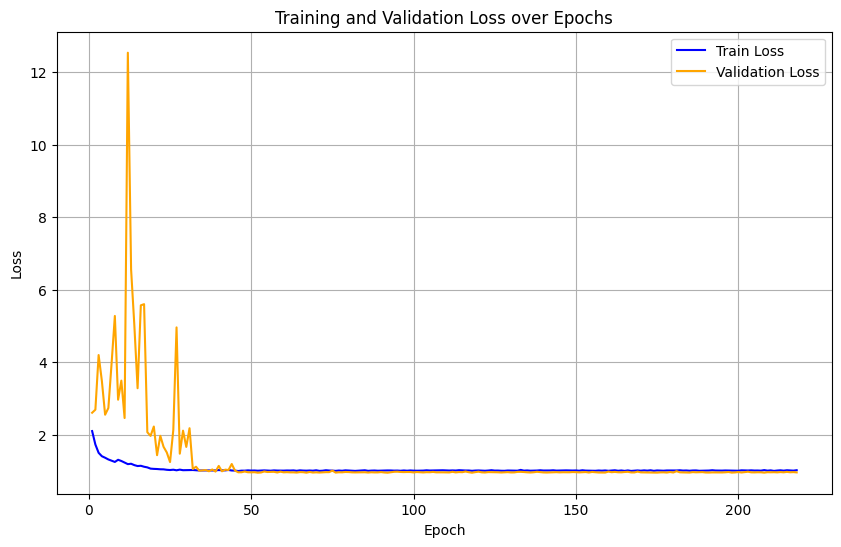

In [22]:
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses_dense, val_losses_dense)

In [23]:
def get_preds_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_preds), torch.cat(all_labels)

In [24]:
def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))

    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
        
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

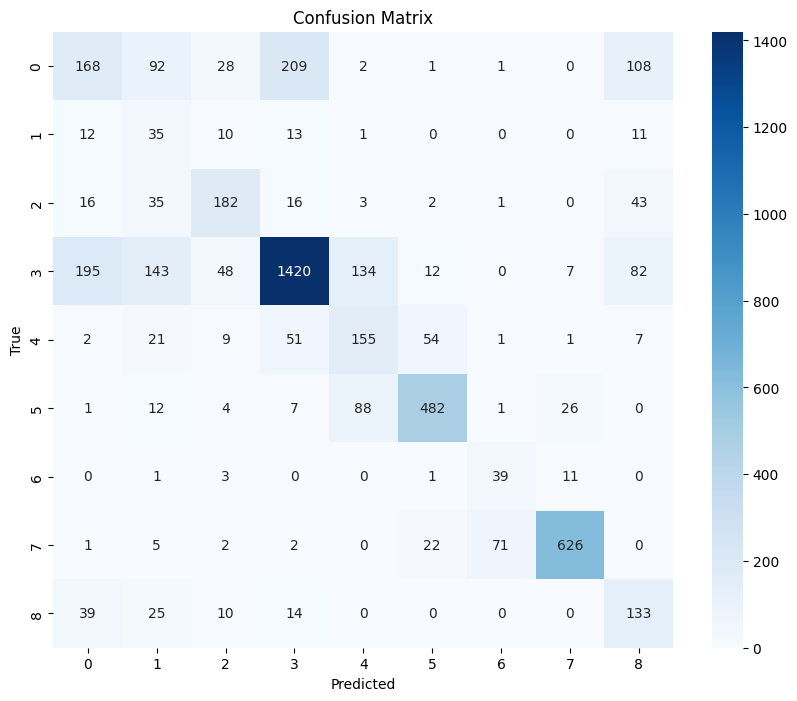

In [25]:
y_pred, y_true = get_preds_labels(StarTrack_Dense_V1, val_loader_tabular, device)

plot_confusion_matrix(y_true, y_pred)

In [29]:
def evaluate_model(model, data_loader, device, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {acc:.4f}')
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))
    return all_labels, all_preds 

In [30]:
y_table_true, y_table_pred = evaluate_model(StarTrack_Dense_V1, test_loader_tabular, device, le_tabular)

Accuracy: 0.6363
Classification Report:
              precision    recall  f1-score   support

           A       0.44      0.25      0.32       609
           B       0.08      0.32      0.12        82
          CV       0.50      0.66      0.57       298
           F       0.81      0.70      0.75      2042
           G       0.38      0.58      0.46       300
           K       0.91      0.70      0.79       621
           L       0.26      0.67      0.37        54
           M       0.89      0.80      0.84       730
          WD       0.31      0.54      0.39       221

    accuracy                           0.64      4957
   macro avg       0.51      0.58      0.51      4957
weighted avg       0.71      0.64      0.66      4957



# Training The LSTM (Spectrogram) Branch

In [44]:
le_spect = LabelEncoder()
labels_encoded_spect = le_spect.fit_transform(labels_spect)
X = spectrograms
X = X.reshape((X.shape[0], X.shape[1], 1))
y = labels_encoded_spect
print("X shape:", X.shape)
print(f'Total samples: {X.shape[0]}')
print(f'Unique classes: {le_spect.classes_}')

X shape: (24782, 1024, 1)
Total samples: 24782
Unique classes: ['A' 'B' 'CV' 'F' 'G' 'K' 'L' 'M' 'WD']


In [47]:
X_spect_train, y_spect_train, X_spect_val, y_spect_val, X_spect_test, y_spect_test = split_sets(X, y)

Train shape: (14868, 1024, 1), (14868,)
Validation shape: (4957, 1024, 1), (4957,)
Test shape: (4957, 1024, 1), (4957,)


In [48]:
X_spect_train_fusion = X_spect_train.copy()
X_spect_val_fusion = X_spect_val.copy()
X_spect_test_fusion = X_spect_test.copy()

y_spect_train_fusion = y_spect_train.copy()
y_spect_val_fusion = y_spect_val.copy()
y_spect_test_fusion = y_spect_test.copy()

In [68]:
train_dataset_spect = TensorDataset(torch.tensor(X_spect_train, dtype=torch.float32), torch.tensor(y_spect_train, dtype=torch.long))
val_dataset_spect = TensorDataset(torch.tensor(X_spect_val, dtype=torch.float32), torch.tensor(y_spect_val, dtype=torch.long))
test_dataset_spect = TensorDataset(torch.tensor(X_spect_test, dtype=torch.float32), torch.tensor(y_spect_test, dtype=torch.long))

train_loader_spect = DataLoader(train_dataset_time, batch_size=64, shuffle=True)
val_loader_spect = DataLoader(val_dataset_time, batch_size=64, shuffle=False)
test_loader_spect = DataLoader(test_dataset_time, batch_size=64, shuffle=False)

In [65]:
# Dataloader needs (B, 1024, 1) shape
class StarTrack_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, output_size=9, num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            dropout=0.5, # Lower/Increase based off testing results
            batch_first=True
        )
        self.bn = nn.BatchNorm1d(hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.bn(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def extract_features(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.bn(x)
        x = F.relu(self.fc1(x))
        return x
        
# Number of classes after grouping = 9

In [66]:
StarTrack_LSTM_V1 = StarTrack_LSTM()
StarTrack_LSTM_V1 = StarTrack_LSTM_V1 .to(device)

In [67]:
class_weights_LSTM = compute_class_weight('balanced', classes=np.unique(y_spect_train), y=y_spect_train)
class_weights_LSTM = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_LSTM)
optimizer_LSTM = torch.optim.Adam(StarTrack_LSTM_V1.parameters(), lr=1e-4, weight_decay=1e-4)

C:\Users\radiant\AppData\Local\Temp\ipykernel_13024\3703655229.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_LSTM = torch.tensor(class_weights, dtype=torch.float).to(device)


In [ ]:
train_losses_LSTM, val_losses_LSTM= train_model(model=StarTrack_LSTM_V1, 
                                       criterion=loss_fn, 
                                       optimizer=optimizer_LSTM, 
                                       epochs=15, 
                                       train_loader=train_loader_spect, 
                                       val_loader=val_loader_spect)

# Training The Fusion Branch

In [ ]:
class StarTrack_Fusion(nn.Module):
    def __init__(self, lstm_model: nn.Module, dense_model: nn.Module,
                 fused_hidden_dim=512, num_classes=9): 
        super().__init__()
        self.lstm_branch = lstm_model
        self.dense_branch = dense_model

        for param in self.lstm_branch.parameters():
            param.requires_grad = False
        for param in self.dense_branch.parameters():
            param.requires_grad = False
            
        for param in self.lstm_branch.fc1.parameters():
            param.requires_grad = True
        for param in self.dense_branch.fc1.parameters():
            param.requires_grad = True

        lstm_output_dim = 256
        dense_output_dim = 64
        
        self.cross_attn = nn.MultiheadAttention(embed_dim=lstm_output_dim, num_heads=4)
        self.fusion = nn.Sequential(
            nn.Linear(lstm_output_dim + dense_output_dim, fused_hidden_dim),
            nn.GELU(),  
            nn.BatchNorm1d(fused_hidden_dim),
            nn.Linear(fused_hidden_dim, fused_hidden_dim//2),
            nn.GELU(),
            nn.Dropout(0.3), 
            nn.Linear(fused_hidden_dim//2, num_classes)
        )
        
        self.lstm_classifier = nn.Linear(lstm_output_dim, num_classes)
        self.dense_classifier = nn.Linear(dense_output_dim, num_classes)
        self.dense_proj = nn.Linear(dense_output_dim, lstm_output_dim)

    def forward(self, lstm_input, dense_input):
            lstm_feat = self.lstm_branch.extract_features(lstm_input)
            dense_feat = self.dense_branch.extract_features(dense_input)
        
            lstm_q = lstm_feat.unsqueeze(0)  
            dense_kv = dense_proj.unsqueeze(0)  

            dense_proj = self.dense_proj(dense_feat) 
           
            attn_out, _ = self.cross_attn(query=lstm_q, key=dense_kv, value=dense_kv)
            attn_out = attn_out.squeeze(0)
        
            lstm_feat = lstm_feat + attn_out      
            fused = torch.cat([lstm_feat, dense_feat], dim=1) 
            out = self.fusion(fused)
        
            lstm_out = self.lstm_classifier(lstm_feat)
            dense_out = self.dense_classifier(dense_feat)
            return out, lstm_out, dense_out
